# Training and maintaining MNIST predictions

In [2]:
import pymongo
import torch
import torchvision

from superduperdb import superduper

In [3]:
class LeNet5(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = torch.nn.Linear(400, 120)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(120, 84)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

    
def postprocess(x):
    return int(x.topk(1)[1].item())


def preprocess(x):
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.1307,), std=(0.3081,))]
    )(x)

In [8]:
db.db.client.drop_database('documents')

In [5]:
db = pymongo.MongoClient().documents

In [7]:
db = superduper(db)

In [9]:
from superduperdb.encoders.pillow.image import pil_image as i
from superduperdb.core.documents import Document as D
from superduperdb.datalayer.mongodb.query import Collection

import random

collection = Collection(name='mnist')

mnist_data = list(torchvision.datasets.MNIST(root='./data', download=True))
data = [D({'img': i(x[0]), 'class': x[1]}) for x in mnist_data]
random.shuffle(data)

db.execute(
    collection.insert_many(data[:-1000], encoders=[i])
)

INFO:root:Created encoder/pil_image/0
INFO:root:found 0 uris


(<pymongo.results.InsertManyResult at 0x17d7beb50>,
 TaskWorkflow(database=<superduperdb.datalayer.base.database.BaseDatabase object at 0x17db79700>, G=<networkx.classes.digraph.DiGraph object at 0x167808bb0>))

In [10]:
db.execute(collection.find_one())

Document({'_id': ObjectId('64b174e4d50ad8f852218d47'), 'img': Encodable(x=<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x17DB797F0>, encoder=Encoder(identifier='pil_image', decoder=<Artifact artifact=<function decode_pil_image at 0x17dbb7ca0> serializer=dill>, encoder=<Artifact artifact=<function encode_pil_image at 0x17d809b80> serializer=dill>, shape=None, version=0)), 'class': 2, '_fold': 'train'})

In [11]:
model = superduper(LeNet5(10), preprocess=preprocess, postprocess=postprocess)

In [12]:
model.predict([r['img'] for r in data[:10]])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 455.96it/s]


[5, 0, 0, 0, 0, 5, 0, 5, 0, 5]

In [13]:
from torch.optim import Adam
from torch.nn.functional import cross_entropy

from superduperdb.core.metric import Metric
from superduperdb.metrics.classification import compute_classification_metrics
from superduperdb.core.dataset import Dataset
from superduperdb.models.torch.wrapper import TorchTrainerConfiguration


job = model.fit(
    X='img',
    y='class',
    db=db,
    select=Collection(name='mnist').find(),
    configuration=TorchTrainerConfiguration(
        identifier='my_configuration',
        objective=cross_entropy,
        loader_kwargs={'batch_size': 10},
        max_iterations=100,
        validation_interval=10,
        compute_metrics=compute_classification_metrics,
    ),
    metrics=[Metric(identifier='acc', object=lambda x, y: x == y)],
    validation_sets=[
        Dataset(
            identifier='my_valid',
            select=Collection(name='mnist').find({'_fold': 'valid'}),
            db=db,
        )
    ],
    distributed=False
)

INFO:root:Created dataset/my_valid/0
INFO:root:Created model/lenet5/0
INFO:root:fold: TRAIN; iteration: 0; objective: 2.2636027336120605; 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2917/2917 [00:01<00:00, 1473.80it/s]
INFO:root:fold: VALID; iteration: 0; my_valid/acc: 0.10558793280767913; objective: 2.3024406808696383; 
INFO:root:fold: TRAIN; iteration: 1; objective: 2.451305389404297; 
INFO:root:fold: TRAIN; iteration: 2; objective: 2.3206772804260254; 
INFO:root:fold: TRAIN; iteration: 3; objective: 2.3094427585601807; 
INFO:root:fold: TRAIN; iteration: 4; objective: 2.27115797996521; 
INFO:root:fold: TRAIN; iteration: 5; objective: 2.251753330230713; 
INFO:root:fold: TRAIN; iteration: 6; objective: 2.184605598449707; 
INFO:root:fold: TRAIN; iteration: 7; objective: 2.1559717655181885; 
INFO:root:fold: TRAIN; iteration: 8; objective: 2.1100094318389893; 
INFO:root:fold: TR

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2917/2917 [00:01<00:00, 1475.50it/s]
INFO:root:fold: VALID; iteration: 80; my_valid/acc: 0.8663009941720946; objective: 0.5408257470045188; 
INFO:root:fold: TRAIN; iteration: 81; objective: 0.5113770365715027; 
INFO:root:fold: TRAIN; iteration: 82; objective: 0.5134092569351196; 
INFO:root:fold: TRAIN; iteration: 83; objective: 0.5849499702453613; 
INFO:root:fold: TRAIN; iteration: 84; objective: 0.6738963723182678; 
INFO:root:fold: TRAIN; iteration: 85; objective: 0.2836281657218933; 
INFO:root:fold: TRAIN; iteration: 86; objective: 0.2135278731584549; 
INFO:root:fold: TRAIN; iteration: 87; objective: 0.6622745990753174; 
INFO:root:fold: TRAIN; iteration: 88; objective: 0.4997749924659729; 
INFO:root:fold: TRAIN; iteration: 89; objective: 0.5573866963386536; 
INFO:root:fold: TRAIN; iteration: 90; objective: 0.24344868957996368; 
100

In [14]:
db.metadata.show_jobs()

[{'identifier': 'c8b53e5e-7ce6-4694-88b9-5c2960341923',
  'time': datetime.datetime(2023, 7, 14, 12, 16, 36, 917000),
  'status': 'success'}]

In [16]:
model

TorchModel(identifier='lenet5', object=<Artifact artifact=LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
) serializer=torch>, encoder=None, train_X='img', train_y='class', training_select=Find(collection=Collection(name='mnist'), like_parent=None, args=[], kwargs={}, type_i

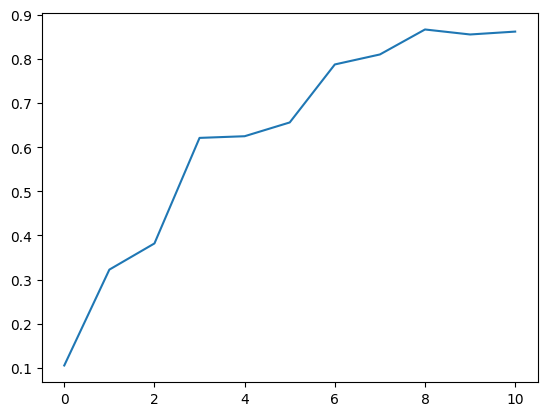

In [15]:
from matplotlib import pyplot as plt

model = db.load('model', model.identifier)

plt.plot(model.metric_values['my_valid/acc'])
plt.show()

In [17]:
from superduperdb.core.watcher import Watcher

jobs = db.add(
    Watcher(
        model=model,
        key='img',
        select=collection.find(),
    )
)

INFO:root:Created watcher/lenet5/img/0
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1388.48it/s]


In [18]:
for r in data[-1000:]:
    r['update'] = True

db.execute(Collection('docs').insert_many(data[-1000:]))

INFO:root:found 0 uris
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1381.18it/s]


(<pymongo.results.InsertManyResult at 0x184090a60>,
 TaskWorkflow(database=<superduperdb.datalayer.base.database.BaseDatabase object at 0x17db79700>, G=<networkx.classes.digraph.DiGraph object at 0x184090ee0>))

In [ ]:
db.execute(Collection('docs').find_one({'update': True}))